In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

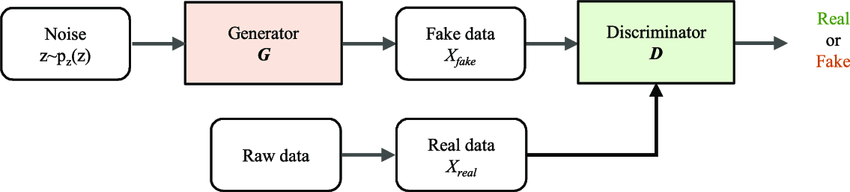

# **1- Importing Required Libraries**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# **2- Loading Handwritten Persian numerals dataset**

In [21]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape(28, 28, 1)  # Changed to [28, 28, 1]
        label = self.data.iloc[idx, 0]  # Dummy label

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNISTDataset('/kaggle/input/handwritten-persian-numerals/train.csv', transform=transform)

batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **3- Building the Generator**

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# **4- Building the Discriminator**

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# **5- Building the CycleGAN Model**

In [24]:
class CycleGAN(nn.Module):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y

    def forward(self, x, y):
        fake_y = self.generator_g(x)
        cycled_x = self.generator_f(fake_y)

        fake_x = self.generator_f(y)
        cycled_y = self.generator_g(fake_x)

        return fake_y, cycled_x, fake_x, cycled_y

# **6- Defining Loss Functions**

In [25]:
criterion_gan = nn.BCELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

optimizer_g = optim.Adam(generator_g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_f = optim.Adam(generator_f.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d_x = optim.Adam(discriminator_x.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d_y = optim.Adam(discriminator_y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# **7- Training the CycleGAN**

In [26]:
def train_cycle_gan(num_epochs, train_loader):
    for epoch in range(num_epochs):
        for i, (real_x, _) in enumerate(train_loader):
            real_x = real_x.to(device)  # Ensure real_x has shape [batch_size, 1, 28, 28]
            real_y = real_x  # For simplicity, using the same dataset for both domains

            # Train Generators
            optimizer_g.zero_grad()
            optimizer_f.zero_grad()

            # GAN loss
            fake_y = generator_g(real_x)
            pred_fake_y = discriminator_y(fake_y)
            loss_gan_g = criterion_gan(pred_fake_y, torch.ones_like(pred_fake_y))

            fake_x = generator_f(real_y)
            pred_fake_x = discriminator_x(fake_x)
            loss_gan_f = criterion_gan(pred_fake_x, torch.ones_like(pred_fake_x))

            # Cycle loss
            cycled_x = generator_f(fake_y)
            loss_cycle_x = criterion_cycle(cycled_x, real_x)

            cycled_y = generator_g(fake_x)
            loss_cycle_y = criterion_cycle(cycled_y, real_y)

            # Identity loss
            identity_x = generator_f(real_x)
            loss_identity_x = criterion_identity(identity_x, real_x)

            identity_y = generator_g(real_y)
            loss_identity_y = criterion_identity(identity_y, real_y)

            # Total loss
            loss_g = loss_gan_g + loss_gan_f + 10 * (loss_cycle_x + loss_cycle_y) + 5 * (loss_identity_x + loss_identity_y)
            loss_g.backward()
            optimizer_g.step()
            optimizer_f.step()

            # Train Discriminators
            optimizer_d_x.zero_grad()
            optimizer_d_y.zero_grad()

            # Discriminator X
            pred_real_x = discriminator_x(real_x)
            loss_real_x = criterion_gan(pred_real_x, torch.ones_like(pred_real_x))

            pred_fake_x = discriminator_x(fake_x.detach())
            loss_fake_x = criterion_gan(pred_fake_x, torch.zeros_like(pred_fake_x))

            loss_d_x = (loss_real_x + loss_fake_x) * 0.5
            loss_d_x.backward()
            optimizer_d_x.step()

            # Discriminator Y
            pred_real_y = discriminator_y(real_y)
            loss_real_y = criterion_gan(pred_real_y, torch.ones_like(pred_real_y))

            pred_fake_y = discriminator_y(fake_y.detach())
            loss_fake_y = criterion_gan(pred_fake_y, torch.zeros_like(pred_fake_y))

            loss_d_y = (loss_real_y + loss_fake_y) * 0.5
            loss_d_y.backward()
            optimizer_d_y.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                      f"Loss G: {loss_g.item():.4f}, Loss D X: {loss_d_x.item():.4f}, Loss D Y: {loss_d_y.item():.4f}")

        # Plotting samples every 5 epochs
        if epoch % 5 == 0:
            generator_g.eval()  # Set generator to eval mode to generate sample images
            with torch.no_grad():
                samples = generator_g(real_x[:16])
            generator_g.train()  # Set generator back to train mode

            fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
                img = img.cpu().detach()
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.imshow(img.squeeze(), cmap='Greys_r')
            plt.show()

# Set device and move models to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator_g = generator_g.to(device)
generator_f = generator_f.to(device)
discriminator_x = discriminator_x.to(device)
discriminator_y = discriminator_y.to(device)

Epoch [0/50] Batch [0/32] Loss G: 31.5657, Loss D X: 0.7281, Loss D Y: 0.6930


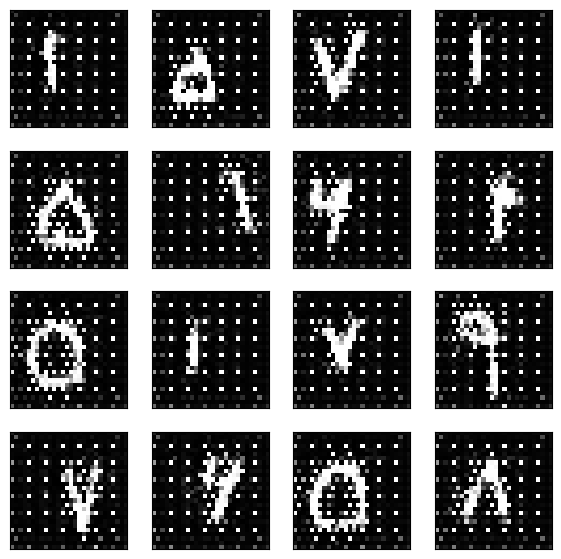

Epoch [1/50] Batch [0/32] Loss G: 8.4654, Loss D X: 0.5213, Loss D Y: 0.1627
Epoch [2/50] Batch [0/32] Loss G: 6.9348, Loss D X: 0.6946, Loss D Y: 0.0564
Epoch [3/50] Batch [0/32] Loss G: 6.3234, Loss D X: 0.6903, Loss D Y: 0.0421
Epoch [4/50] Batch [0/32] Loss G: 6.6682, Loss D X: 0.6910, Loss D Y: 0.0187
Epoch [5/50] Batch [0/32] Loss G: 6.9168, Loss D X: 0.6922, Loss D Y: 0.0138


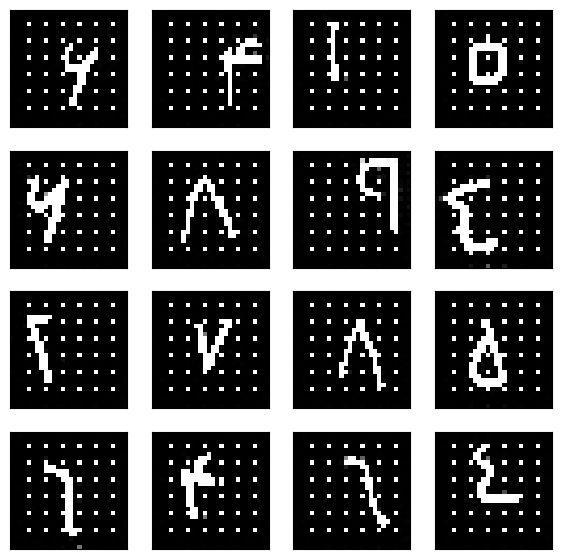

Epoch [6/50] Batch [0/32] Loss G: 7.0876, Loss D X: 0.6915, Loss D Y: 0.0103
Epoch [7/50] Batch [0/32] Loss G: 7.4140, Loss D X: 0.6914, Loss D Y: 0.0073
Epoch [8/50] Batch [0/32] Loss G: 7.5715, Loss D X: 0.6917, Loss D Y: 0.0062
Epoch [9/50] Batch [0/32] Loss G: 7.7504, Loss D X: 0.6916, Loss D Y: 0.0048
Epoch [10/50] Batch [0/32] Loss G: 8.0061, Loss D X: 0.6933, Loss D Y: 0.0048


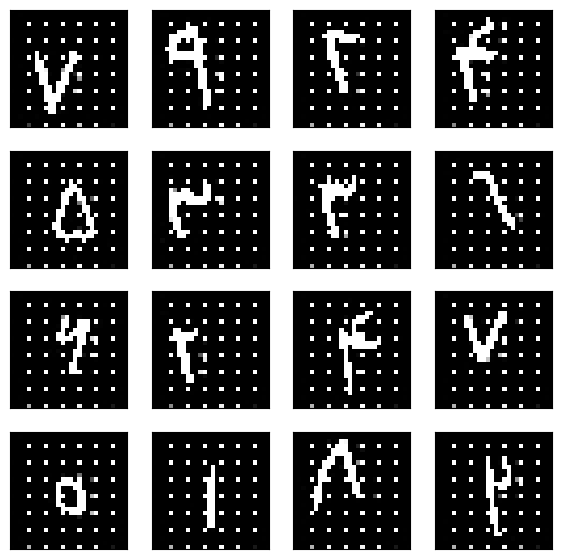

Epoch [11/50] Batch [0/32] Loss G: 8.2912, Loss D X: 0.6932, Loss D Y: 0.0031
Epoch [12/50] Batch [0/32] Loss G: 8.2313, Loss D X: 0.6924, Loss D Y: 0.0030
Epoch [13/50] Batch [0/32] Loss G: 8.4214, Loss D X: 0.6930, Loss D Y: 0.0023
Epoch [14/50] Batch [0/32] Loss G: 8.5669, Loss D X: 0.6927, Loss D Y: 0.0019
Epoch [15/50] Batch [0/32] Loss G: 8.6261, Loss D X: 0.6929, Loss D Y: 0.0020


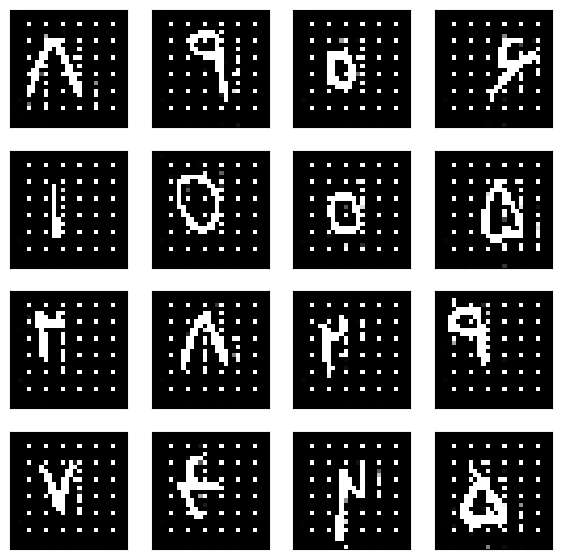

Epoch [16/50] Batch [0/32] Loss G: 8.7683, Loss D X: 0.6924, Loss D Y: 0.0019
Epoch [17/50] Batch [0/32] Loss G: 8.9975, Loss D X: 0.6926, Loss D Y: 0.0022
Epoch [18/50] Batch [0/32] Loss G: 1.8176, Loss D X: 0.6927, Loss D Y: 0.8163
Epoch [19/50] Batch [0/32] Loss G: 1.5120, Loss D X: 0.6933, Loss D Y: 0.7000
Epoch [20/50] Batch [0/32] Loss G: 1.4161, Loss D X: 0.6950, Loss D Y: 0.6961


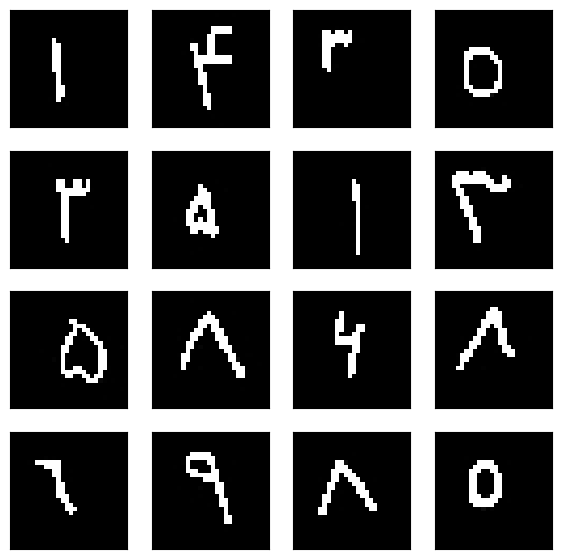

Epoch [21/50] Batch [0/32] Loss G: 1.4462, Loss D X: 0.6934, Loss D Y: 0.6955
Epoch [22/50] Batch [0/32] Loss G: 1.4071, Loss D X: 0.6933, Loss D Y: 0.6959
Epoch [23/50] Batch [0/32] Loss G: 1.3732, Loss D X: 0.6941, Loss D Y: 0.6949
Epoch [24/50] Batch [0/32] Loss G: 1.4880, Loss D X: 0.6940, Loss D Y: 0.6948
Epoch [25/50] Batch [0/32] Loss G: 1.4029, Loss D X: 0.6935, Loss D Y: 0.6943


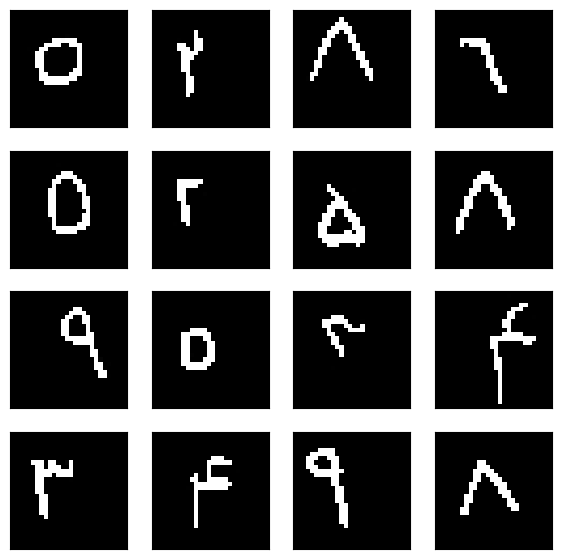

Epoch [26/50] Batch [0/32] Loss G: 1.4053, Loss D X: 0.6934, Loss D Y: 0.6942
Epoch [27/50] Batch [0/32] Loss G: 1.3967, Loss D X: 0.6933, Loss D Y: 0.6941
Epoch [28/50] Batch [0/32] Loss G: 1.4353, Loss D X: 0.6933, Loss D Y: 0.6941
Epoch [29/50] Batch [0/32] Loss G: 1.4088, Loss D X: 0.6935, Loss D Y: 0.6940
Epoch [30/50] Batch [0/32] Loss G: 1.3830, Loss D X: 0.6934, Loss D Y: 0.6937


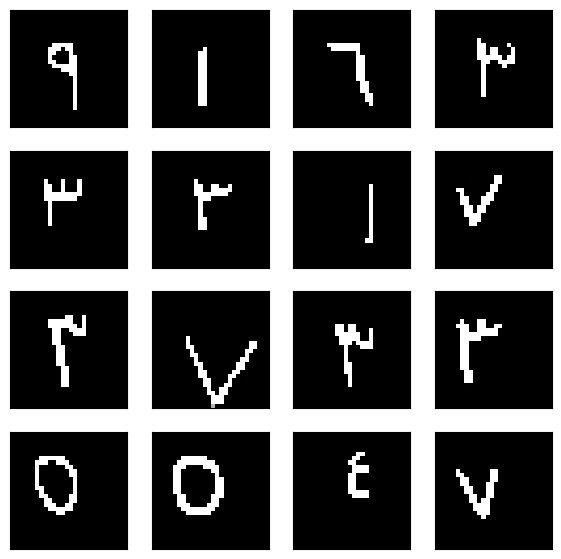

Epoch [31/50] Batch [0/32] Loss G: 1.4038, Loss D X: 0.6933, Loss D Y: 0.6939
Epoch [32/50] Batch [0/32] Loss G: 1.4788, Loss D X: 0.6940, Loss D Y: 0.6942
Epoch [33/50] Batch [0/32] Loss G: 1.3778, Loss D X: 0.6932, Loss D Y: 0.6940
Epoch [34/50] Batch [0/32] Loss G: 1.4045, Loss D X: 0.6933, Loss D Y: 0.6937
Epoch [35/50] Batch [0/32] Loss G: 1.3774, Loss D X: 0.6935, Loss D Y: 0.6936


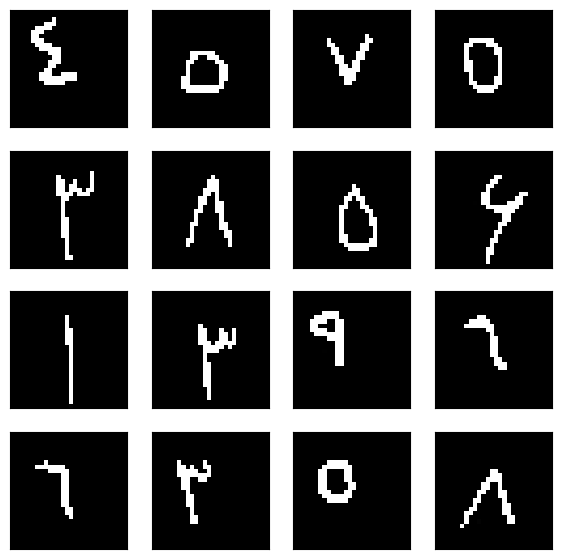

Epoch [36/50] Batch [0/32] Loss G: 1.4010, Loss D X: 0.6935, Loss D Y: 0.6940
Epoch [37/50] Batch [0/32] Loss G: 1.4003, Loss D X: 0.6929, Loss D Y: 0.6935
Epoch [38/50] Batch [0/32] Loss G: 1.3776, Loss D X: 0.6929, Loss D Y: 0.6938
Epoch [39/50] Batch [0/32] Loss G: 1.3962, Loss D X: 0.6930, Loss D Y: 0.6938
Epoch [40/50] Batch [0/32] Loss G: 1.4174, Loss D X: 0.6933, Loss D Y: 0.6936


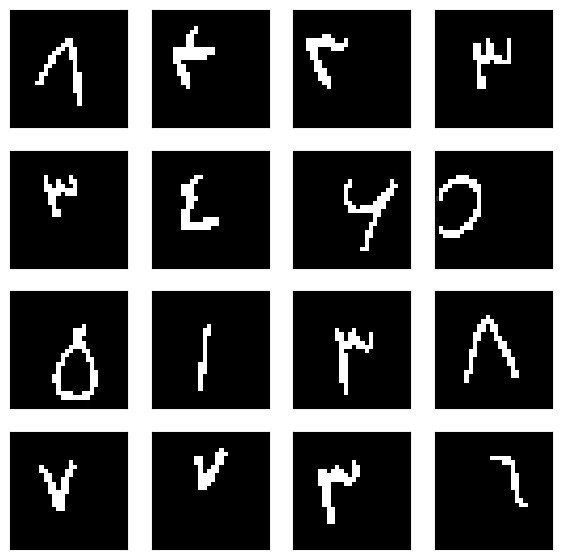

Epoch [41/50] Batch [0/32] Loss G: 1.4098, Loss D X: 0.6932, Loss D Y: 0.6936
Epoch [42/50] Batch [0/32] Loss G: 1.4539, Loss D X: 0.6932, Loss D Y: 0.6943
Epoch [43/50] Batch [0/32] Loss G: 1.4340, Loss D X: 0.6934, Loss D Y: 0.6951
Epoch [44/50] Batch [0/32] Loss G: 1.4082, Loss D X: 0.6931, Loss D Y: 0.6936
Epoch [45/50] Batch [0/32] Loss G: 1.4543, Loss D X: 0.6933, Loss D Y: 0.6954


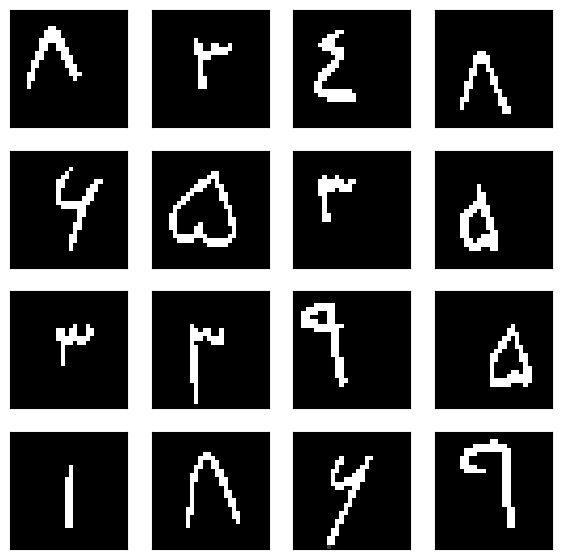

Epoch [46/50] Batch [0/32] Loss G: 1.3728, Loss D X: 0.6930, Loss D Y: 0.6935
Epoch [47/50] Batch [0/32] Loss G: 1.3827, Loss D X: 0.6930, Loss D Y: 0.6934
Epoch [48/50] Batch [0/32] Loss G: 1.3701, Loss D X: 0.6930, Loss D Y: 0.6936
Epoch [49/50] Batch [0/32] Loss G: 1.4046, Loss D X: 0.6933, Loss D Y: 0.6934


In [27]:
# Train CycleGAN
train_cycle_gan(num_epochs=50, train_loader=train_loader)